In [16]:
import tensorflow as tf
import matplotlib
import numpy as np
import csv
import os
import pandas as pd
import cv2

In [3]:
%matplotlib inline

In [25]:
file = "/Users/hpnhxxwn/Desktop/jiaowang/driving_log.csv"

In [28]:
log = pd.read_csv(file)

In [71]:
print(log.iloc[0].iloc[0])
img = cv2.imread(log.iloc[0].iloc[0])
steering_angle = log.iloc[0].iloc[6]

/Users/hpnhxxwn/Desktop/jiaowang/IMG/center_2017_11_25_13_36_19_859.jpg


In [41]:
from matplotlib import pyplot as plt

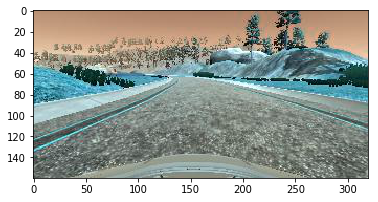

In [42]:
plt.imshow(img)

In [43]:
img_left = cv2.imread(log.iloc[0].iloc[1])

In [44]:
img_right = cv2.imread(log.iloc[0].iloc[2])

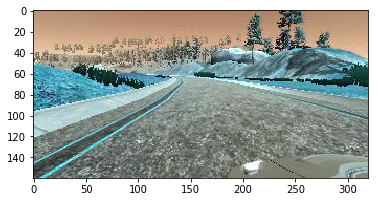

In [46]:
plt.imshow(img_left)

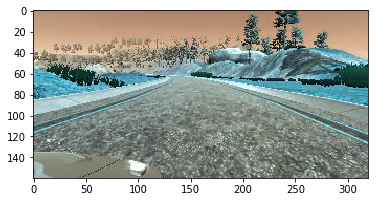

In [47]:
plt.imshow(img_right)

In [62]:
steering = log.iloc[:,6]

In [63]:
steering.max()

30.18993

In [64]:
steering.min()

2.9557009999999998e-07

In [65]:
steering.mean()

16.62716389879084

In [66]:
steering.median()

16.319975

In [99]:
rows, cols, ch = img.shape

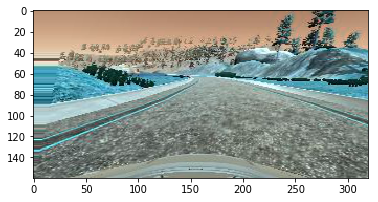

In [107]:
shear_range = 100
dx = np.random.randint(-shear_range, shear_range + 1)
random_point = [cols / 2 + dx, rows / 2]
pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
pts2 = np.float32([[0, rows], [cols, rows], random_point])
dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
M = cv2.getAffineTransform(pts1, pts2)
image = cv2.warpAffine(img, M, (cols, rows), borderMode=1)
steering_angle += dsteering
plt.imshow(image)

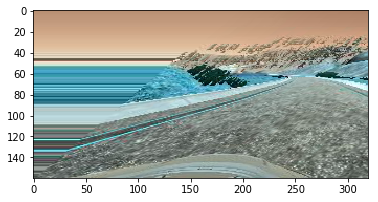

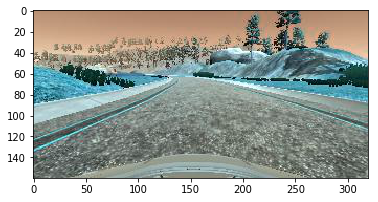

In [108]:
plt.imshow(img)

In [142]:
image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

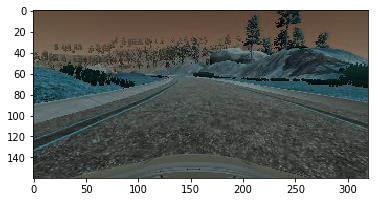

In [143]:
image1 = np.array(image, dtype = np.float64)
random_bright = .5+np.random.uniform()
image1[:,:,2] = image1[:,:,2]*random_bright
image1[:,:,2][image1[:,:,2]>255]  = 255
image1 = np.array(image1, dtype = np.uint8)
image1 = cv2.cvtColor(image1, cv2.COLOR_HSV2RGB)
plt.imshow(image1)

In [112]:
image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

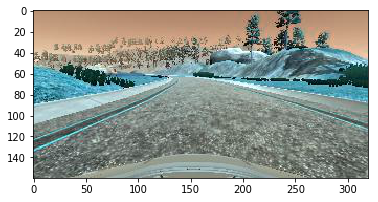

In [113]:
plt.imshow(image)

In [148]:
gamma = 0.4 + np.random.uniform(0.4, 1.5)
power = 1.0 / gamma
table = np.array([((i / 255.0) ** power) * 255 for i in np.arange(0, 256)]).astype("uint8")
#return cv2.LUT(img, table)
img_gamma = cv2.LUT(img, table)

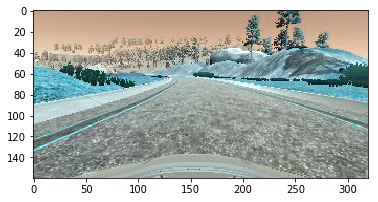

In [149]:
plt.imshow(img_gamma)

In [150]:
DRIVING_LOG_FILE = '/Users/hpnhxxwn/Desktop/jiaowang/driving_log.csv'

In [151]:
def load_data(path):
    log = np.read_csv(path)

def crop(img, up, down):
    '''
    :param img: image
    :param up: top percentage to crop, must be in the range of [0, 50)
    :param down: bottom percentage to crop, must be in the range of [0, 50)
    :return: the cropped image
    '''
    # assert up < 0.5
    # assert down < 0.5

    h, w, c = img.shape
    top = int(h * up)

    bottom = int(h - down * h)
    return img[top:bottom, :, :]

def flip(img, angle):
    '''
    :param img: image
    :param angle: steering angle
    :return: the flipped image
    :return: flipped steering angle
    '''
    h, w, c = img.shape
    dst = cv2.flip(img, 1) # Flip image vertically
    return dst, -angle


In [152]:
def random_shear(img, steering_angle, shear_range=200):
    """
    Source: https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.7k8vfppvk
    :param image: Source image on which the shear operation will be applied
    :param steering_angle: The steering angle of the image
    :param shear_range: Random shear between [-shear_range, shear_range + 1] will be applied
    :return: The image generated by applying random shear on the source image
    """
    rows, cols, ch = img.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    img = cv2.warpAffine(img, M, (cols, rows), borderMode=1)
    steering_angle += dsteering

    return img, steering_angle

def random_brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    image = np.array(image, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image[:,:,2] = image[:,:,2]*random_bright
    image[:,:,2][image[:,:,2]>255]  = 255
    image = np.array(image, dtype = np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    return image

In [153]:
def gamma_brightness(img, gamma=1.0):
    '''
    :param img: Source image on which the brightness ajust will be applied
    :param gamma: Gamma parameter
    :return: New image generated by gamma brightness correction
    '''
    power = 1.0 / gamma
    table = np.array([((i / 255.0) ** power) * 255
                for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

def random_rotation(img, steering_angle, rotation_amount=15):
    """
    :param img:
    :param steering_angle:
    :param rotation_amount:
    :return:
    """
    angle = np.random.uniform(-rotation_amount, rotation_amount + 1)
    h, w, c = img.shape
    M = cv2.getRotationMatrix2D((H/2, W/2), angle, 1.0)
    rad = (np.pi / 180.0) * angle
    dst = cv2.warpAffine(img, M, (w, h))
    return dst, steering_angle + (-1) * rad

In [155]:
def generate_image(img, steering_angle, top_crop_percent=0.35, bottom_crop_percent=0.1, do_shear_prob=0.9):
    """
    :param img:
    :param steering_angle:
    :param top_crop_percent:
    :param bottom_crop_percent:
    :param do_shear_prob:
    :param shear_range:
    :return:
    """
    # head = bernoulli.rvs(do_shear_prob)
    if np.random.uniform() >= 0.7:
        img, steering_angle = random_shear(image, steering_angle)

    img = crop(img, top_crop_percent, bottom_crop_percent)

    if np.random.uniform() < 0.5:
        img, steering_angle = random_flip(img, steering_angle)
    # gamma = np.random.uniform(0.4, 1.5)
    # if gamma != 1.0:
    #     img = gamma_brightness(img, gamma)
    img = random_brightness(img)

    # img = resize(img, resize_dim)

    return img, steering_angle

In [156]:
def get_next_image_files(batch_size=64):
    """
    The simulator records three images (namely: left, center, and right) at a given time
    However, when we are picking images for training we randomly (with equal probability)
    one of these three images and its steering angle.

    :param batch_size:
        Size of the image batch

    :return:
        An list of selected (image files names, respective steering angles)
    """
    data = pd.read_csv(DRIVING_LOG_FILE)
    num_of_img = len(data)
    rnd_indices = np.random.randint(0, num_of_img, batch_size)

    image_files_and_angles = []
    for index in rnd_indices:
        rnd_image = np.random.randint(0, 3)
        if rnd_image == 0:
            img = data.iloc[index][1].strip() # left
            angle = data.iloc[index][6] + SHIFT_ANG
            image_files_and_angles.append((img, angle))

        elif rnd_image == 1:
            img = data.iloc[index][0].strip()
            angle = data.iloc[index][6]
            image_files_and_angles.append((img, angle))
        else:
            img = data.iloc[index][2].strip()
            angle = data.iloc[index][6] - SHIFT_ANG
            image_files_and_angles.append((img, angle))

    return image_files_and_angles

In [157]:
def generate_next_batch(batch_size=64):
    """
    This generator yields the next training batch

    :param batch_size:
        Number of training images in a single batch

    :return:
        A tuple of features and steering angles as two numpy arrays
    """
    while True:
        X_batch = []
        y_batch = []
        images = get_next_image_files(batch_size)
        for img_file, angle in images:
            raw_image = plt.imread(img_file)
            raw_angle = angle
            new_image, new_angle = generate_new_image(raw_image, raw_angle)
            X_batch.append(new_image)
            y_batch.append(new_angle)

        assert len(X_batch) == batch_size, 'len(X_batch) == batch_size should be True'

        yield np.array(X_batch), np.array(y_batch)

def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.004
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    h, w, c = image.shape
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

In [162]:
from utils import *
import pandas as pd

In [163]:
get_next_image_files()

NameError: name 'pd' is not defined